## Run below 10 cells only if you running this file in colab

In [ ]:
# !rm -r test

rm: cannot remove 'test': No such file or directory


In [ ]:
# !rm -r train

rm: cannot remove 'train': No such file or directory


In [ ]:
# !rm dog-breed-identification.zip

rm: cannot remove 'dog-breed-identification.zip': No such file or directory


In [ ]:
# !rm labels.csv

rm: cannot remove 'labels.csv': No such file or directory


In [ ]:
# !rm sample_submission.csv

rm: cannot remove 'sample_submission.csv': No such file or directory


In [1]:
# ! mkdir ~/.kaggle 

In [2]:
# ! cp kaggle.json ~/.kaggle/

In [3]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# !kaggle competitions download -c dog-breed-identification

100% 689M/691M [00:30<00:00, 25.3MB/s]
100% 691M/691M [00:30<00:00, 24.0MB/s]


In [5]:
# ! unzip -qq dog-breed-identification

# Importing libraries

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import  Dataset
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder

In [7]:
if torch.cuda.is_available():
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev)

# Data preprocessing

In [8]:
data_folder="."

In [9]:
train_data_path=f'{data_folder}/train'
test_data_path=f'{data_folder}/test'

In [10]:
df=pd.read_csv(f'{data_folder}/labels.csv')
df['file_name']=df['id']+'.jpg'

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['breed'])

In [11]:
labels=df['breed'].unique()

In [12]:
from sklearn.model_selection import train_test_split
df_train, df_test= train_test_split(df[['file_name','label_encoded']], test_size=0.20, random_state=42)

In [13]:
df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

In [14]:
print(df_train.shape,df_test.shape)
df_test.head(3)

(8177, 2) (2045, 2)


,file_name,label_encoded
0,475171ec5847e4df41847e295b8cfca2.jpg,111
1,70c412a3ce894c617cbe707f24adbb82.jpg,56
2,c13427fc3db9194dac02b1721bd10fe4.jpg,97


# Fine tuning pretrained model 

In [16]:
# !pip install -q transformers    #Run only once

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 92.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 78.1 MB/s eta 0:00:00


In [17]:
EPOCHS = 3
BATCH_SIZE = 32
LEARNING_RATE = 2e-5

In [18]:
# - Define image transformations using PyTorch's torchvision.transforms module
# - These transformations will be applied to both the training and testing datasets
# - RandomResizedCrop: randomly crops the image and resizes it to a specific size
# - RandomHorizontalFlip: randomly flips the image horizontally
# - ToTensor: converts the image to a PyTorch tensor
# - Normalize: normalizes the image pixel values with mean and standard deviation values

from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]
print(processor.size)
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=image_mean, std=image_std)
train_transform = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

test_transform = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

{'height': 224, 'width': 224}


In [19]:
# Custom dataset class for PyTorch.
# The class should inherit from the Dataset class and override the __len__ and __getitem__ methods.
# In this example, the class takes in a list of data samples and transforms them using the specified transforms.
# The __getitem__ method returns a tuple of the transformed input and the label.
# The transforms can include data augmentation, normalization, and other preprocessing steps.
# This custom dataset can then be used in conjunction with PyTorch's DataLoader to load the data in batches.


class CustomDataLoader(Dataset):
    def __init__(self, dataset, img_dir, transform=None):
        self.img_labels = dataset
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        inputs=self.transform(image)
        input_label={}
        input_label['pixel_values']=inputs
        input_label['labels']=label
        return input_label

In [20]:
train_dataset=CustomDataLoader(dataset=df_train,img_dir=train_data_path,transform=train_transform)
test_dataset=CustomDataLoader(dataset=df_test,img_dir=train_data_path,transform=test_transform)

train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset,batch_size=BATCH_SIZE-16)

In [21]:
batch = next(iter(train_loader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([32, 3, 224, 224])
labels torch.Size([32])


In [22]:
assert batch['pixel_values'].shape == (BATCH_SIZE, 3, 224, 224)
assert batch['labels'].shape == (BATCH_SIZE,)

In [23]:
next(iter(test_loader))['pixel_values'].shape,next(iter(train_loader))['pixel_values'].shape

(torch.Size([16, 3, 224, 224]), torch.Size([32, 3, 224, 224]))

In [24]:
# Pretrained PyTorch model class.

from transformers import ViTForImageClassification

class ModelClass(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224',
                                                              num_labels=len(labels),
                                                              id2label={i: c for i, c in enumerate(labels)},
                                                              label2id={c: i for i, c in enumerate(labels)},
                                                              ignore_mismatched_sizes=True)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits

In [26]:
## Using Native pytorch to train model on our dataset

torch.manual_seed(101)
model = ModelClass()
model.to(device)
# model.load_state_dict(torch.load("/content/drive/MyDrive/mmmut/dog-breed-identification.pt",map_location=device))     ### Run this line only if you already trained model saved.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([120, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([120]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Trainind model for fine tuning

In [27]:
def train_eval_test(dataloader,train=1,epoch=0):
    total_iteration=0
    total_loss=0
    total_correct=0
    total_datapoints=0
    if(train):
        model.train()
        for inputLabel in tqdm(dataloader,total=len(dataloader), desc=f'Epoch {epoch+1} Training'):
            x=inputLabel['pixel_values'].to(device)
            y=inputLabel['labels'].to(device)
            x=x.to(device)
            y=y.to(device)
            y_pred=model(x)
            loss=criterion(y_pred,y)
            
            total_loss+=loss.detach().item()
            total_iteration+=1
            
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y).sum().item()
            total_correct += batch_corr
            total_datapoints+=x.shape[0]
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    else:
        with torch.no_grad():
            model.eval()
            for inputLabel in tqdm(dataloader,total=len(dataloader), desc=f'Epoch {epoch+1} Testing '):
                x=inputLabel['pixel_values'].to(device)
                y=inputLabel['labels'].to(device)
                x=x.to(device)
                y=y.to(device)
                y_pred=model(x)
                loss=criterion(y_pred,y)
                
                total_loss+=loss.detach().item()
                
                predicted = torch.max(y_pred.data, 1)[1]
                batch_corr = (predicted == y).sum().item()
                total_correct += batch_corr
                total_datapoints+=x.shape[0]
    accuracy=round((total_correct/total_datapoints)*100,2)
    loss=round(total_loss/len(dataloader),2)
    return accuracy,loss

Epoch 4: Train accuracy: 86.45% Train loss: 0.57
Epoch 4: Evaluation accuracy: 86.45% Evaluation loss: 0.49


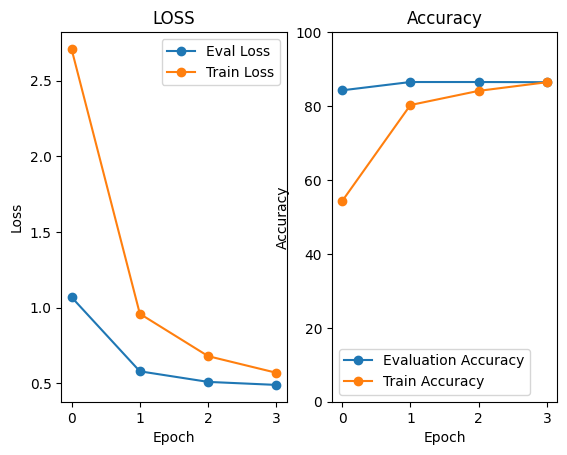

In [29]:
from IPython.display import clear_output

epochs=4
train_losses=[]
eval_losses=[]
train_accuracy=[]
eval_accuracy=[]
for epoch in range(epochs):
    Taccuracy,Tloss=train_eval_test(train_loader,1,epoch)
    train_accuracy.append(Taccuracy)
    train_losses.append(Tloss)

    Eaccuracy,Eloss=train_eval_test(test_loader,0,epoch)
    eval_losses.append(Eloss)
    eval_accuracy.append(Eaccuracy)

    clear_output(wait=True)
    print(f"Epoch {epoch+1}: Train accuracy: {train_accuracy[-1]}% Train loss: {train_losses[-1]}")
    print(f"Epoch {epoch+1}: Evaluation accuracy: {eval_accuracy[-1]}% Evaluation loss: {eval_losses[-1]}")
    
    
    
    plt.subplot(1,2,1)
    plt.plot(range(epoch+1),eval_losses,label='Eval Loss',marker='o')
    plt.plot(range(epoch+1),train_losses, label='Train Loss',marker='o')
    plt.title("LOSS")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(epoch+1),eval_accuracy,marker='o',label='Evaluation Accuracy')
    plt.plot(range(epoch+1),train_accuracy,marker='o', label='Train Accuracy')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(ymin=0,ymax=100)
    plt.legend(loc='best')

    plt.show()

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Notes/Dog-breed-Identification/Dogbreed_PreTrained_Pytorch_Native.pth')

# Testing trained model
## This model trained on google colab and trained model's weights and biases used here

In [32]:
model = ModelClass()
model.to(device)
model.eval()
print()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([120, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([120]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
### Testing model performance before loading model_state_dict

correct=0
total=0
for x in tqdm(test_loader,total=len(test_loader)):
    x_input=x['pixel_values'].to(device)
    y_pred=model(x_input)
    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == x['labels'].to(device)).sum().item()
    correct += batch_corr
    total += x['pixel_values'].shape[0]
    # print(x['pixel_values'].shape[0])
print(total,correct)
print("Accuracy is:",round((correct/total)*100,2),"%")

100%|██████████| 128/128 [00:41<00:00,  3.10it/s]

2045 22
Accuracy is: 1.08 %


In [34]:
### Testing model performance after loading model_state_dict

model.load_state_dict(torch.load('/content/drive/MyDrive/Notes/Dog-breed-Identification/Dogbreed_PreTrained_Pytorch_Native.pth',map_location=torch.device('cpu')))
model.eval()
model.to(device)

correct=0
total=0
for x in tqdm(test_loader,total=len(test_loader)):
    x_input=x['pixel_values'].to(device)
    y_pred=model(x_input)
    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == x['labels'].to(device)).sum().item()
    correct += batch_corr
    total += x['pixel_values'].shape[0]
    # print(x['pixel_values'].shape[0])
print(total,correct)
print("Accuracy is:",round((correct/total)*100,2),"%")

100%|██████████| 128/128 [00:32<00:00,  3.89it/s]

2045 1768
Accuracy is: 86.45 %


# Now we can use API for futher development